In [121]:
import os
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
from torchvision.models import detection
import cv2
from PIL import Image
import random
import json

# Load Data and Preprocess

In [122]:
label_map = {'attack':1,'nospace':2,'noore':3}
label_count = {3:0,1:0,2:0}

In [123]:
class EVEDataset(Dataset):
    def __init__(self, root):
        # roots
        self.root = root
        self.images_root = os.path.join(root, 'images')
        self.anns_root = os.path.join(root,'annotations')
        
        # data
        self.image_paths = []
        self.targets = []
        
        self.initialize()
    def initialize(self):
        annotations = os.listdir(self.anns_root)
        for ann in annotations:
            ann_path = os.path.join(self.anns_root,ann)
            with open(ann_path, 'r') as file:
                data = dict(json.load(file))
                image_path = os.path.join(self.images_root,data['imagePath'])
                boxes = []
                labels = []
                objects = data['shapes']
                random.shuffle(objects)
                for obj in objects:
                    label = label_map[obj['label']]
                    label_count[label]+=1
                    box = obj['points']
                    box = [box[0][0],box[0][1],box[1][0],box[1][1]]
                    boxes.append(box)
                    labels.append(label)
                self.targets.append({"boxes": torch.tensor(boxes), "labels": torch.tensor(labels)}) 
                self.image_paths.append(image_path)
              
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = ToTensor()(image)
        target = self.targets[idx]
        return image, target

In [124]:
data_train = EVEDataset("data")

In [125]:
label_count

{3: 10, 1: 11, 2: 10}

# Create Dataloader

In [126]:
def collate(x):
    return tuple(zip(*x))
batch_size = 2
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True,collate_fn=collate)

# Model Construction

In [127]:
# load pretrained Faster R-CNN model
model = detection.fasterrcnn_resnet50_fpn_v2(weights = detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

# change box_predictor
num_classes = len(label_map) + 1 # number of classes plus background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# setup device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# setup optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train

In [128]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    
    # train
    epoch_loss = 0
    for images, targets in train_loader:
        # load data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()}  for t in targets]
        # print(targets)
        
        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()*2
        

    print(f"Epoch: {epoch}, Loss: {epoch_loss/len(data_train)}")
        
    lr_scheduler.step() 

print("Training completed.")

Epoch: 0, Loss: 1.2989298780759175
Epoch: 1, Loss: 0.43703410228093464
Epoch: 2, Loss: 0.300128107269605
Epoch: 3, Loss: 0.2901896208524704
Epoch: 4, Loss: 0.22724421123663585
Epoch: 5, Loss: 0.15856994489828746
Epoch: 6, Loss: 0.1258400152126948
Epoch: 7, Loss: 0.10621508608261744
Epoch: 8, Loss: 0.0861969734231631
Epoch: 9, Loss: 0.06335130284229915
Training completed.


# Evaluation

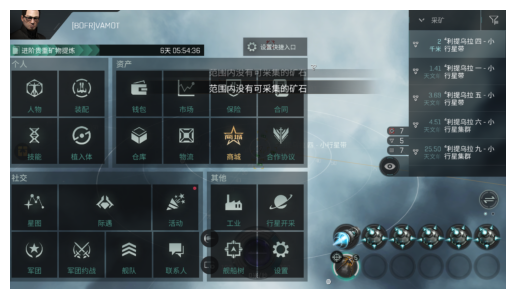

In [129]:
img_id = 1
img=cv2.imread(data_train.image_paths[img_id],cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
plt.axis('off')
plt.show()

In [130]:
image, target = data_train[img_id]
print(type(image))
image=image.to(device)
target = {k: v.to(device) for k,v in target.items()}
model.eval()
with torch.no_grad():
    output = model([image])

<class 'torch.Tensor'>


In [131]:
output[0]

{'boxes': tensor([[1032.2760,  775.2773, 1075.7780,  820.3317],
         [ 638.4937,  238.7935,  957.6777,  273.6669],
         [ 639.7087,  191.9267,  963.7633,  220.4741],
         [ 561.4642,  241.6414, 1079.8788,  272.0254]], device='cuda:0'),
 'labels': tensor([1, 3, 3, 2], device='cuda:0'),
 'scores': tensor([0.9804, 0.9531, 0.9451, 0.1383], device='cuda:0')}

In [132]:
detections = output[0]
for i in range(len(detections["boxes"])):
    label=detections['labels'][i]
    box=detections['boxes'][i]
    score=detections['scores'][i]
    if score>0.9:
        if box[2]>box[0] and box[3]>box[1]:
            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)

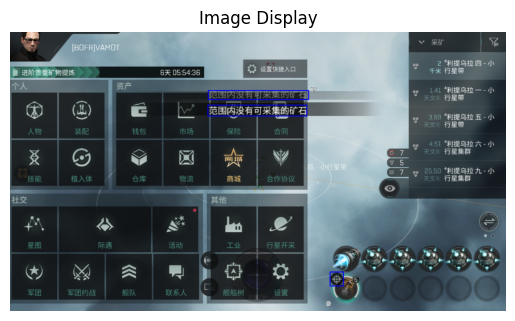

In [133]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Image Display')
plt.axis('off') 
plt.show()

In [134]:
torch.save(model, "assets/models/eve_mining.pth")